In [1]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from scipy.stats import ranksums

import glob
import os
import matplotlib.pyplot as plt

from modules.utilities import *
from modules.constants import *
from modules import CliffsDelta
from scipy.stats import shapiro
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio

np.random.seed(42)

plt.rcParams.update(mpl_params)
pio.templates.default = "custom_matplotlib_like"

TOPIC_DIR = "./Outputs/BERTopic/Topics"
DATA_DIR = "./Outputs/PerformancePRs"

In [2]:
commit_df = read_aidev(FileName.POP_PR_COMMIT_DETAILS)
commit_df

,sha,pr_id,author,committer,message,commit_stats_total,commit_stats_additions,commit_stats_deletions,filename,status,additions,deletions,changes,patch
0,2f9d54dda4f0c87c19e0bbeb9936f525d0587e16,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Add llms.txt compilation system for AI model d...,23008,23008,0,.github/workflows/compile-llms-txt.yml,added,38.0,0.0,38.0,"@@ -0,0 +1,38 @@\n+name: Compile llms.txt\n+\n..."
1,2f9d54dda4f0c87c19e0bbeb9936f525d0587e16,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Add llms.txt compilation system for AI model d...,23008,23008,0,docs/compile_llms_txt.py,added,47.0,0.0,47.0,"@@ -0,0 +1,47 @@\n+import os\n+from pathlib im..."
2,2f9d54dda4f0c87c19e0bbeb9936f525d0587e16,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Add llms.txt compilation system for AI model d...,23008,23008,0,llms.txt,added,22923.0,0.0,22923.0,None
3,dbd1b5f129f7cffa5ce284d7255814c98bcc38a2,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Fix lint issues: remove unused variable and ap...,35,18,17,docs/compile_llms_txt.py,modified,18.0,17.0,35.0,"@@ -1,47 +1,48 @@\n import os\n from pathlib i..."
4,c2659cfdedf666c8f14753d71664563c2a932b23,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Update llms.txt to follow official standard wi...,23035,89,22946,docs/compile_llms_txt.py,modified,51.0,36.0,87.0,"@@ -3,45 +3,60 @@\n \n \n def compile_llms_txt..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
711918,b779b9b95559531dd5eb8a213815489d2b600ffa,3246680171,max-sixty,max-sixty,Add CLAUDE.md for development guidelines\n\nTh...,53,53,0,CLAUDE.md,added,53.0,0.0,53.0,"@@ -0,0 +1,53 @@\n+# numbagg Development Guide..."
711919,8382774ef0824b4476c0bb37284404dc3abb89d4,3246680171,pre-commit-ci[bot],pre-commit-ci[bot],[pre-commit.ci] auto fixes from pre-commit.com...,4,2,2,CLAUDE.md,modified,2.0,2.0,4.0,"@@ -49,5 +49,5 @@ uv run pytest numbagg/test/t..."
711920,a3087c2958122f85ff94ae3ccb99db789f8d450e,3114327280,dsp-ant,dsp-ant,Rename ResourceReference to ResourceTemplateRe...,44,22,22,schema/draft/schema.json,modified,20.0,20.0,40.0,"@@ -339,7 +339,7 @@\n ..."
711921,a3087c2958122f85ff94ae3ccb99db789f8d450e,3114327280,dsp-ant,dsp-ant,Rename ResourceReference to ResourceTemplateRe...,44,22,22,schema/draft/schema.ts,modified,2.0,2.0,4.0,"@@ -1117,7 +1117,7 @@ export interface ModelHi..."


In [3]:
def get_time_to_merge(df, unit='days'):
    df['created_at'] = pd.to_datetime(df['created_at'])
    df['merged_at'] = pd.to_datetime(df['merged_at'])
    time_diff = (df['merged_at'] - df['created_at']).dt.total_seconds()
    
    if unit == 'days':
        time_to_merge = time_diff / 86400
    elif unit == 'hours':
        time_to_merge = time_diff / 3600
    elif unit == 'minutes':
        time_to_merge = time_diff / 60
    elif unit == 'seconds':
        time_to_merge = time_diff
    else:
        raise ValueError("Invalid unit. Use 'days', 'hours', 'minutes', or 'seconds'.")
    
    return time_to_merge


def get_merge_stats(df, name, unit='days'):
    time_to_merge = get_time_to_merge(df, unit=unit)

    stats = {
        'name': name,
        'min': time_to_merge.min(),
        'max': time_to_merge.max(),
        'mean': time_to_merge.mean(),
        'median': time_to_merge.median(),
        '10th': time_to_merge.quantile(0.1),
        '90th': time_to_merge.quantile(0.9),
    }

    return stats

def get_change_details(df):
    df = df.copy()
    df["additions"] = 0.0
    df["deletions"] = 0.0
    df["changes"] = 0.0
    for index, row in df.iterrows():
        pr_id = row["id"]
        commit_rows = commit_df[commit_df["pr_id"] == pr_id]

        df.at[index, "num_commits"] = commit_rows["sha"].unique().shape[0]
        df.at[index, "additions"] = commit_rows["additions"].sum()
        df.at[index, "deletions"] = commit_rows["deletions"].sum()
        df.at[index, "changes"] = commit_rows["changes"].sum()
    return df


In [4]:
perf_df = pd.read_csv(os.path.join(DATA_DIR, "POP_PULL_Requests_LLM_filtered_final.csv"))
perf_ids = perf_df["id"].tolist()
perf_df.shape

(1221, 14)

In [5]:
pop_df = read_aidev(FileName.POP_PULL_REQUEST)
non_perf_df = pop_df[~pop_df["id"].isin(perf_ids)]
non_perf_df

,id,number,title,body,agent,user_id,user,state,created_at,closed_at,merged_at,repo_id,repo_url,html_url
0,3264933329,2911,Fix: Wait for all partitions in load_collectio...,## Summary\n\nFixes an issue where `load_colle...,Claude_Code,108661493,weiliu1031,closed,2025-07-26T02:59:01Z,2025-07-29T07:01:20Z,None,191751505,https://api.github.com/repos/milvus-io/pymilvus,https://github.com/milvus-io/pymilvus/pull/2911
1,3265118634,2,ファイルパス参照を相対パスに統一し、doc/からdocs/に統一,## 背景\n\n現在、本プロジェクトにおいて以下のパス構成の不整合が生じています：\n\n...,Claude_Code,61827001,cm-kojimat,closed,2025-07-26T04:56:55Z,2025-07-26T22:12:24Z,2025-07-26T22:12:24Z,1025472321,https://api.github.com/repos/classmethod/tsumiki,https://github.com/classmethod/tsumiki/pull/2
2,3265640341,30,Add build staleness detection for debug CLI,## Summary\r\n\r\n Implements comprehensive b...,Claude_Code,7475,MSch,closed,2025-07-26T13:31:19Z,2025-07-26T13:37:22Z,2025-07-26T13:37:22Z,988488798,https://api.github.com/repos/steipete/Peekaboo,https://github.com/steipete/Peekaboo/pull/30
3,3265709660,205,feat: add comprehensive README screenshots wit...,## Type of Change\n\n- [ ] 🐛 `bug` - Bug fix (...,Claude_Code,80381,sugyan,closed,2025-07-26T14:07:22Z,2025-07-26T14:45:30Z,2025-07-26T14:45:30Z,999285986,https://api.github.com/repos/sugyan/claude-cod...,https://github.com/sugyan/claude-code-webui/pu...
4,3265782173,17625,chore: remove HashedPostStateProvider trait,## Summary\r\n\r\n#17545 \r\n\r\nRemove the un...,Claude_Code,47593288,adust09,open,2025-07-26T15:02:48Z,None,None,537233603,https://api.github.com/repos/paradigmxyz/reth,https://github.com/paradigmxyz/reth/pull/17625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33591,2857942945,2,fix: improve dark mode input focus and toggle ...,# UI Improvements: Dark Mode Input Focus and T...,Devin,158243242,devin-ai-integration[bot],closed,2025-02-17T13:57:22Z,2025-02-17T14:40:12Z,2025-02-17T14:40:12Z,934090141,https://api.github.com/repos/jina-ai/deepsearc...,https://github.com/jina-ai/deepsearch-ui/pull/2
33592,2857959763,2154,docs: add required packages to SeleniumScrapin...,Fixes #2153\n\nThe SeleniumScrapingTool docume...,Devin,158243242,devin-ai-integration[bot],closed,2025-02-17T14:04:15Z,2025-02-25T16:39:21Z,None,710601088,https://api.github.com/repos/crewAIInc/crewAI,https://github.com/crewAIInc/crewAI/pull/2154
33593,2858280902,775,Fix heap buffer overflow in BundlePacket,This PR fixes a heap buffer overflow in Bundle...,Devin,158243242,devin-ai-integration[bot],closed,2025-02-17T16:15:35Z,2025-02-17T16:23:53Z,None,21134745,https://api.github.com/repos/wolfSSL/wolfssh,https://github.com/wolfSSL/wolfssh/pull/775
33594,2858429985,346,Improve environment variable documentation,# Environment Variable Documentation Improveme...,Devin,158243242,devin-ai-integration[bot],closed,2025-02-17T17:19:32Z,2025-02-18T08:32:15Z,2025-02-18T08:32:15Z,894659403,https://api.github.com/repos/goat-sdk/goat,https://github.com/goat-sdk/goat/pull/346


In [6]:
topics = {}
for topic_file in glob.glob(os.path.join(TOPIC_DIR, "*.csv")):
    if "-1" not in topic_file:
        topic_name = os.path.basename(topic_file).replace(".csv", "")
        df = pd.read_csv(topic_file)
        topics[topic_name] = df

In [7]:
total_prs = sum([len(df) for df in topics.values()])
print(f"Total PRs across all topics: {total_prs}")

Total PRs across all topics: 1120


In [8]:
category_dfs = {}
for category, topic_list in category_map.items():
    dfs_to_concat = []
    for topic in topic_list:
        df = topics[topic].copy()
        df['topic_name'] = topic_map.get(topic, topic)
        df['category'] = category
        dfs_to_concat.append(df)
    
    if dfs_to_concat:
        category_dfs[category] = pd.concat(dfs_to_concat, ignore_index=True)

total = 0
for category, df in category_dfs.items():
    total += len(df)
    print(f"{category}: {len(df)} PRs")
print(f"Total PRs across all categories: {total}")

Development: 222 PRs
Low-level: 257 PRs
UI: 136 PRs
Caching: 87 PRs
Algorithmic: 119 PRs
Query: 61 PRs
Networking: 96 PRs
Analytics: 61 PRs
Hardware: 49 PRs
AI: 32 PRs
Total PRs across all categories: 1120


In [9]:
non_perf_df["category"] = "Non-Performance"
non_perf_df["topic_name"] = "N/A"
category_dfs["Non-Performance"] = non_perf_df

/var/folders/fz/gkgx65n92ng3dbh3ypb6nxpc0000gn/T/ipykernel_2225/1035869157.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_perf_df["category"] = "Non-Performance"
/var/folders/fz/gkgx65n92ng3dbh3ypb6nxpc0000gn/T/ipykernel_2225/1035869157.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_perf_df["topic_name"] = "N/A"


In [10]:
all_categories_df = pd.concat(category_dfs.values(), ignore_index=True)

In [11]:
all_categories_df

,id,number,title,body,agent,user_id,user,state,created_at,closed_at,merged_at,repo_id,repo_url,html_url,Topic,Probability,Representative_document,topic_name,category
0,2912546402,448,Add GitHub API caching to prevent rate limiting,- Create GitHub API caching script that handle...,Claude_Code,1021104,8enmann,closed,2025-03-12T03:51:34Z,2025-05-06T17:50:00Z,NaN,937253475,https://api.github.com/repos/anthropics/claude...,https://github.com/anthropics/claude-code/pull...,0.0,1.0,False,CI/CD,Development
1,3216159293,110,Add vcpkg dependency caching to Windows CI wor...,## Overview\n\nThis PR implements vcpkg depend...,Copilot,198982749,Copilot,closed,2025-07-09T14:30:39Z,2025-07-09T16:47:00Z,2025-07-09T16:47:00Z,564439013,https://api.github.com/repos/pelicanmapping/rocky,https://github.com/pelicanmapping/rocky/pull/110,0.0,1.0,False,CI/CD,Development
2,3195588879,16531,Remove duplicate yarn eslint step from .circle...,<details><summary>&#x1F6E0 DevTools &#x1F6E0</...,Copilot,198982749,Copilot,closed,2025-07-02T11:33:06Z,2025-07-02T12:24:50Z,2025-07-02T12:24:50Z,136202695,https://api.github.com/repos/mlflow/mlflow,https://github.com/mlflow/mlflow/pull/16531,0.0,1.0,False,CI/CD,Development
3,3074681764,13829,Update build documentation with quick build op...,This PR updates the build documentation (`tool...,Copilot,198982749,Copilot,open,2025-05-19T18:25:04Z,NaN,NaN,281765424,https://api.github.com/repos/microsoft/azurelinux,https://github.com/microsoft/azurelinux/pull/1...,0.0,1.0,False,CI/CD,Development
4,3159826481,184,[WIP] Support .coshrc compilation,Thanks for assigning this issue to me. I'm sta...,Copilot,198982749,Copilot,closed,2025-06-19T10:34:39Z,2025-06-26T11:59:32Z,NaN,445862991,https://api.github.com/repos/tomhrr/cosh,https://github.com/tomhrr/cosh/pull/184,0.0,1.0,False,CI/CD,Development
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33490,2857942945,2,fix: improve dark mode input focus and toggle ...,# UI Improvements: Dark Mode Input Focus and T...,Devin,158243242,devin-ai-integration[bot],closed,2025-02-17T13:57:22Z,2025-02-17T14:40:12Z,2025-02-17T14:40:12Z,934090141,https://api.github.com/repos/jina-ai/deepsearc...,https://github.com/jina-ai/deepsearch-ui/pull/2,NaN,NaN,NaN,N/A,Non-Performance
33491,2857959763,2154,docs: add required packages to SeleniumScrapin...,Fixes #2153\n\nThe SeleniumScrapingTool docume...,Devin,158243242,devin-ai-integration[bot],closed,2025-02-17T14:04:15Z,2025-02-25T16:39:21Z,None,710601088,https://api.github.com/repos/crewAIInc/crewAI,https://github.com/crewAIInc/crewAI/pull/2154,NaN,NaN,NaN,N/A,Non-Performance
33492,2858280902,775,Fix heap buffer overflow in BundlePacket,This PR fixes a heap buffer overflow in Bundle...,Devin,158243242,devin-ai-integration[bot],closed,2025-02-17T16:15:35Z,2025-02-17T16:23:53Z,None,21134745,https://api.github.com/repos/wolfSSL/wolfssh,https://github.com/wolfSSL/wolfssh/pull/775,NaN,NaN,NaN,N/A,Non-Performance
33493,2858429985,346,Improve environment variable documentation,# Environment Variable Documentation Improveme...,Devin,158243242,devin-ai-integration[bot],closed,2025-02-17T17:19:32Z,2025-02-18T08:32:15Z,2025-02-18T08:32:15Z,894659403,https://api.github.com/repos/goat-sdk/goat,https://github.com/goat-sdk/goat/pull/346,NaN,NaN,NaN,N/A,Non-Performance


In [12]:
closed_df = all_categories_df[all_categories_df['state'] == 'closed']
status = closed_df["merged_at"].apply(lambda x: 'Accepted' if pd.notna(x) else 'Rejected')
closed_df["status"] = status.to_list()
closed_df

/var/folders/fz/gkgx65n92ng3dbh3ypb6nxpc0000gn/T/ipykernel_2225/618948031.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  closed_df["status"] = status.to_list()


,id,number,title,body,agent,user_id,user,state,created_at,closed_at,merged_at,repo_id,repo_url,html_url,Topic,Probability,Representative_document,topic_name,category,status
0,2912546402,448,Add GitHub API caching to prevent rate limiting,- Create GitHub API caching script that handle...,Claude_Code,1021104,8enmann,closed,2025-03-12T03:51:34Z,2025-05-06T17:50:00Z,NaN,937253475,https://api.github.com/repos/anthropics/claude...,https://github.com/anthropics/claude-code/pull...,0.0,1.0,False,CI/CD,Development,Rejected
1,3216159293,110,Add vcpkg dependency caching to Windows CI wor...,## Overview\n\nThis PR implements vcpkg depend...,Copilot,198982749,Copilot,closed,2025-07-09T14:30:39Z,2025-07-09T16:47:00Z,2025-07-09T16:47:00Z,564439013,https://api.github.com/repos/pelicanmapping/rocky,https://github.com/pelicanmapping/rocky/pull/110,0.0,1.0,False,CI/CD,Development,Accepted
2,3195588879,16531,Remove duplicate yarn eslint step from .circle...,<details><summary>&#x1F6E0 DevTools &#x1F6E0</...,Copilot,198982749,Copilot,closed,2025-07-02T11:33:06Z,2025-07-02T12:24:50Z,2025-07-02T12:24:50Z,136202695,https://api.github.com/repos/mlflow/mlflow,https://github.com/mlflow/mlflow/pull/16531,0.0,1.0,False,CI/CD,Development,Accepted
4,3159826481,184,[WIP] Support .coshrc compilation,Thanks for assigning this issue to me. I'm sta...,Copilot,198982749,Copilot,closed,2025-06-19T10:34:39Z,2025-06-26T11:59:32Z,NaN,445862991,https://api.github.com/repos/tomhrr/cosh,https://github.com/tomhrr/cosh/pull/184,0.0,1.0,False,CI/CD,Development,Rejected
5,3259387186,4471,Fix Gradle build failures due to Maven Central...,## Problem\n\nCI jobs were failing due to Mave...,Copilot,198982749,Copilot,closed,2025-07-24T10:28:36Z,2025-07-24T12:17:19Z,2025-07-24T12:17:19Z,511141524,https://api.github.com/repos/valkey-io/valkey-...,https://github.com/valkey-io/valkey-glide/pull...,0.0,1.0,False,CI/CD,Development,Accepted
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33490,2857942945,2,fix: improve dark mode input focus and toggle ...,# UI Improvements: Dark Mode Input Focus and T...,Devin,158243242,devin-ai-integration[bot],closed,2025-02-17T13:57:22Z,2025-02-17T14:40:12Z,2025-02-17T14:40:12Z,934090141,https://api.github.com/repos/jina-ai/deepsearc...,https://github.com/jina-ai/deepsearch-ui/pull/2,NaN,NaN,NaN,N/A,Non-Performance,Accepted
33491,2857959763,2154,docs: add required packages to SeleniumScrapin...,Fixes #2153\n\nThe SeleniumScrapingTool docume...,Devin,158243242,devin-ai-integration[bot],closed,2025-02-17T14:04:15Z,2025-02-25T16:39:21Z,None,710601088,https://api.github.com/repos/crewAIInc/crewAI,https://github.com/crewAIInc/crewAI/pull/2154,NaN,NaN,NaN,N/A,Non-Performance,Rejected
33492,2858280902,775,Fix heap buffer overflow in BundlePacket,This PR fixes a heap buffer overflow in Bundle...,Devin,158243242,devin-ai-integration[bot],closed,2025-02-17T16:15:35Z,2025-02-17T16:23:53Z,None,21134745,https://api.github.com/repos/wolfSSL/wolfssh,https://github.com/wolfSSL/wolfssh/pull/775,NaN,NaN,NaN,N/A,Non-Performance,Rejected
33493,2858429985,346,Improve environment variable documentation,# Environment Variable Documentation Improveme...,Devin,158243242,devin-ai-integration[bot],closed,2025-02-17T17:19:32Z,2025-02-18T08:32:15Z,2025-02-18T08:32:15Z,894659403,https://api.github.com/repos/goat-sdk/goat,https://github.com/goat-sdk/goat/pull/346,NaN,NaN,NaN,N/A,Non-Performance,Accepted


In [13]:
print("Rejected PRs:", closed_df[closed_df["status"] == "Rejected"].shape[0])
print("percentage Rejected PRs:", (closed_df[closed_df["status"] == "Rejected"].shape[0] / closed_df.shape[0]) * 100)
print("Accepted PRs:", closed_df[closed_df["status"] == "Accepted"].shape[0])
print("percentage Accepted PRs:", (closed_df[closed_df["status"] == "Accepted"].shape[0] / closed_df.shape[0]) * 100)

Rejected PRs: 7224
percentage Rejected PRs: 23.157557300849497
Accepted PRs: 23971
percentage Accepted PRs: 76.84244269915051


In [14]:
closed_perf_df  = closed_df[closed_df["category"] != "Non-Performance"]
print("Rejected PRs:", closed_perf_df[closed_perf_df["status"] == "Rejected"].shape[0])
print("percentage Rejected PRs:", (closed_perf_df[closed_perf_df["status"] == "Rejected"].shape[0] / closed_perf_df.shape[0]) * 100)
print("Accepted PRs:", closed_perf_df[closed_perf_df["status"] == "Accepted"].shape[0])
print("percentage Accepted PRs:", (closed_perf_df[closed_perf_df["status"] == "Accepted"].shape[0] / closed_perf_df.shape[0]) * 100)

Rejected PRs: 360
percentage Rejected PRs: 36.54822335025381
Accepted PRs: 625
percentage Accepted PRs: 63.45177664974619


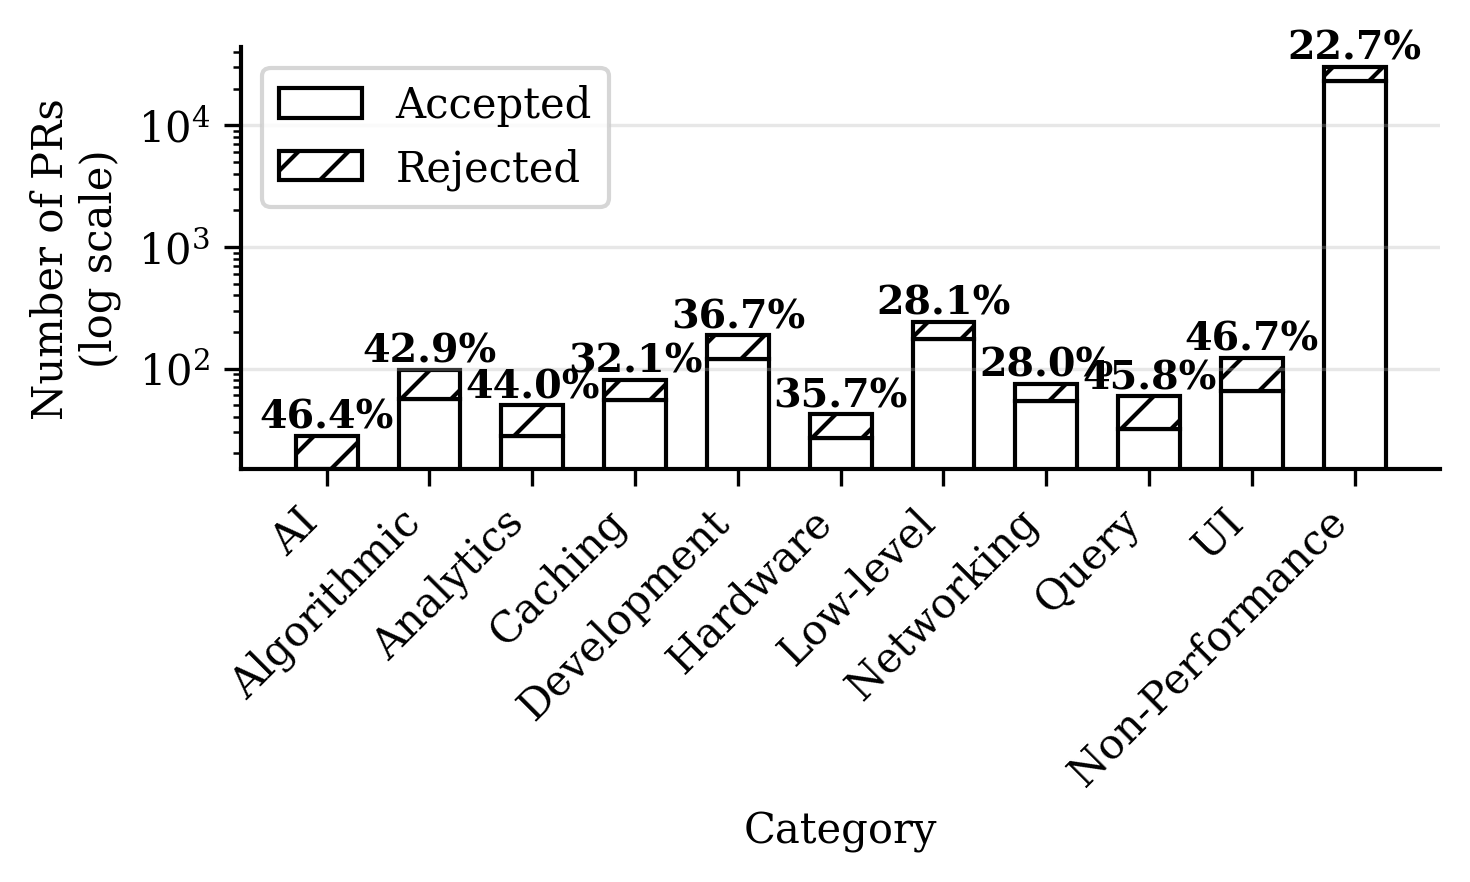

In [15]:
# Prepare data for stacked bar chart
grouped_data = closed_df.groupby(['agent', 'category', 'status'])['id'].nunique().reset_index(name='count')

# Get unique agents and categories
agents = sorted(closed_df['agent'].unique())
categories = sorted(closed_df['category'].unique())

categories.remove("Non-Performance")
categories.append("Non-Performance")

# Prepare data for matplotlib
fig, ax = plt.subplots(figsize=(5, 3))

# Set up positions for bars
x_pos = np.arange(len(categories))
bar_width = 0.6

# Prepare data arrays for accepted and rejected
accepted_counts = []
rejected_counts = []

for category in categories:
    mask_accepted = (grouped_data['category'] == category) & (grouped_data['status'] == 'Accepted')
    mask_rejected = (grouped_data['category'] == category) & (grouped_data['status'] == 'Rejected')
    
    accepted = grouped_data[mask_accepted]['count'].sum() if mask_accepted.any() else 0
    rejected = grouped_data[mask_rejected]['count'].sum() if mask_rejected.any() else 0
    
    accepted_counts.append(accepted)
    rejected_counts.append(rejected)

# Create stacked bars
bars1 = ax.bar(x_pos, accepted_counts, bar_width, label='Accepted', color = "#ffffff",  edgecolor='black')
bars2 = ax.bar(x_pos, rejected_counts, bar_width, bottom=accepted_counts, color = "#ffffff", 
               label='Rejected', hatch='//', edgecolor='black')

# Add percentage labels for rejected PRs
for i, (accepted, rejected) in enumerate(zip(accepted_counts, rejected_counts)):
    total = accepted + rejected
    if total > 0:
        percentage = (rejected / total) * 100
        # Position label at the top of the bar
        ax.text(x_pos[i], total, f'{percentage:.1f}%', 
                ha='center', va='bottom', fontsize=9.5, fontweight='bold')

# Customize the plot
ax.set_xlabel('Category')
ax.set_ylabel('Number of PRs\n(log scale)')
ax.set_xticks(x_pos)
ax.set_xticklabels(categories, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_yscale('log')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig("./Outputs/Figures/RQ2_Accepted_Rejected_StackedBar.pdf", dpi=300, format='pdf', bbox_inches='tight')
plt.show()


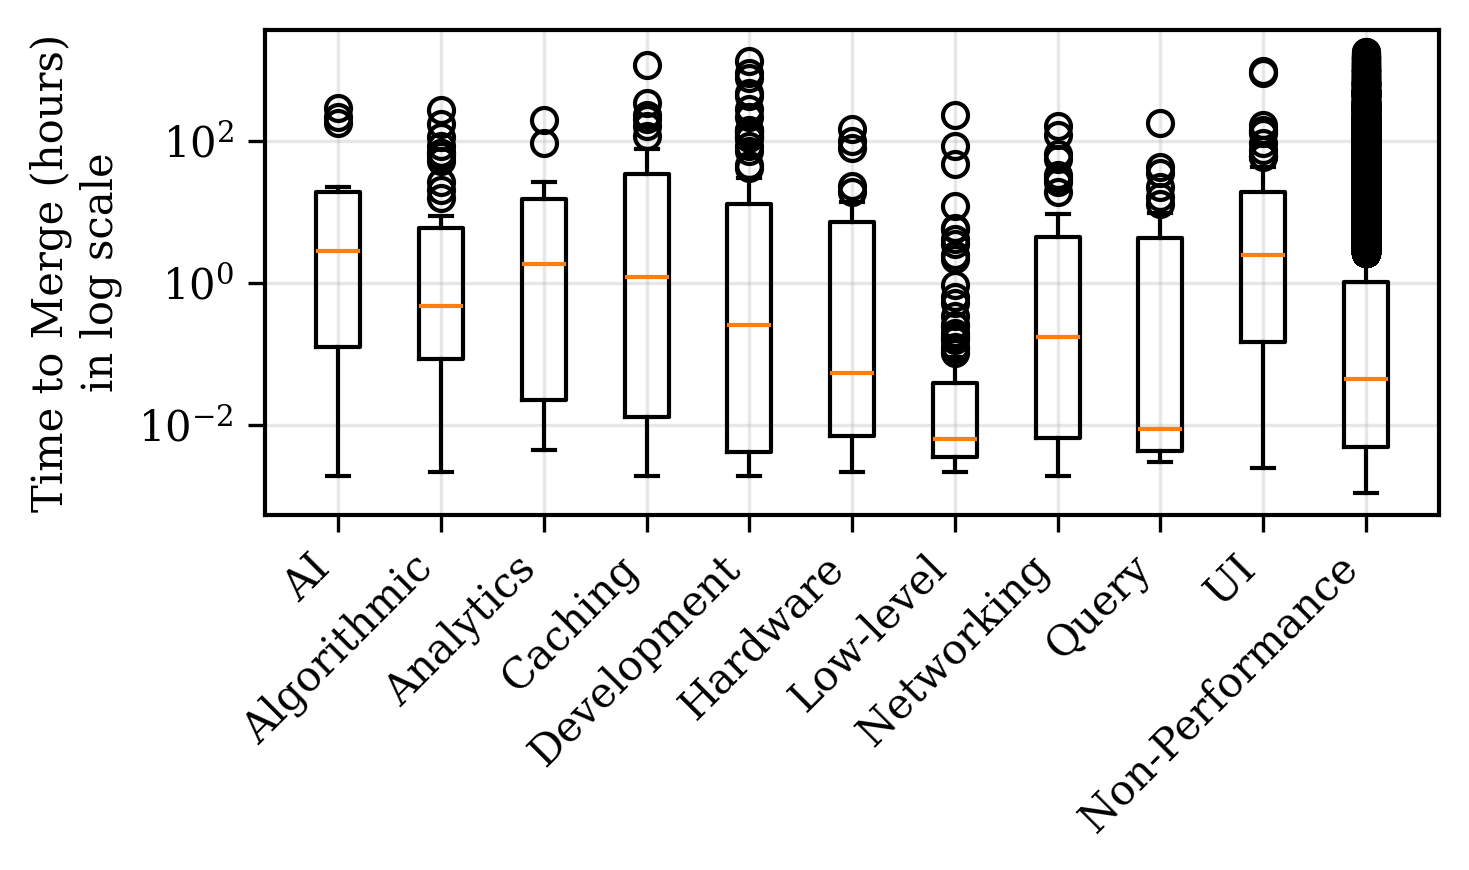

In [16]:

times_to_merge = []
median = []
labels = []

unit = "hours"

for category, df in category_dfs.items():
    df = df.copy()[~pd.isna(df["merged_at"])]
    merge_times = get_time_to_merge(df, unit=unit)
    times_to_merge.append(merge_times)
    median.append(np.median(merge_times))
    labels.append(category)
    
stat = pd.DataFrame({
    'Category': labels,
    'Median': median,
    'TimeToMerge': times_to_merge
})

stat = stat.sort_values(by='Category', ascending=True)

mask = stat['Category'] != "Non-Performance"

stat_unmoved = stat[mask]
stat_moved = stat[~mask]
stat = pd.concat([stat_unmoved, stat_moved], ignore_index=True)

plt.figure(figsize=(5, 3))
positions = np.arange(len(stat)) * 0.7
plt.boxplot(stat["TimeToMerge"], positions=positions, widths=0.3)
plt.xticks(positions, stat["Category"], rotation=45, ha='right')
plt.yscale('log')
plt.ylabel(f'Time to Merge ({unit})\nin log scale')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("./Outputs/Figures/RQ2_TimeToMerge_by_Category.pdf", dpi=300, bbox_inches='tight', format='pdf')
plt.show()

In [17]:
from scipy.stats import ranksums
from itertools import combinations

# Perform pairwise Wilcoxon rank-sum test and Cliff's Delta
categories = stat['Category'].tolist()
results = []

for cat1, cat2 in combinations(range(len(categories)), 2):
    data1 = stat.iloc[cat1]['TimeToMerge']
    data2 = stat.iloc[cat2]['TimeToMerge']
    
    # Wilcoxon rank-sum test
    statistic, p_value = ranksums(data1, data2)
    
    # Cliff's Delta
    delta = CliffsDelta.cliffsDelta(data1, data2)
    
    results.append({
        'Category 1': categories[cat1],
        'Category 2': categories[cat2],
        'W-statistic': statistic,
        'p-value': p_value,
        'is_significant': p_value < 0.05,
        'Cliff\'s Delta': delta[0],
        'Effect Size': delta[1],
    })

comparison_df = pd.DataFrame(results)
comparison_df

,Category 1,Category 2,W-statistic,p-value,is_significant,Cliff's Delta,Effect Size
0,AI,Algorithmic,0.676123,4.989623e-01,False,0.114286,negligible
1,AI,Analytics,0.382235,7.022868e-01,False,0.071429,negligible
2,AI,Caching,0.486646,6.265090e-01,False,0.082424,negligible
3,AI,Development,1.312555,1.893329e-01,False,0.208403,small
4,AI,Hardware,1.299374,1.938157e-01,False,0.244444,small
5,AI,Low-level,4.033736,5.489710e-05,True,0.628352,large
6,AI,Networking,1.483882,1.378403e-01,False,0.251852,small
7,AI,Query,2.065370,3.888796e-02,True,0.377083,medium
8,AI,UI,-0.073960,9.410422e-01,False,-0.012308,negligible
9,AI,Non-Performance,2.370458,1.776605e-02,True,0.353488,medium


In [18]:

# Perform Wilcoxon rank-sum test and Cliff's Delta for Performance vs Non-Performance
perf_time = stat[stat['Category'] != 'Non-Performance']['TimeToMerge'].explode()
non_perf_time = stat[stat['Category'] == 'Non-Performance']['TimeToMerge'].explode()

# Wilcoxon rank-sum test
statistic, p_value = ranksums(perf_time, non_perf_time)

# Cliff's Delta
delta = CliffsDelta.cliffsDelta(perf_time, non_perf_time)

print(f"Performance vs Non-Performance Time to Merge")
print(f"W-statistic: {statistic}")
print(f"p-value: {p_value}")
print(f"Significant (p < 0.05): {p_value < 0.05}")
print(f"Cliff's Delta: {delta[0]}")
print(f"Effect Size: {delta[1]}")

Performance vs Non-Performance Time to Merge
W-statistic: 1.972392739835898
p-value: 0.04856478999936991
Significant (p < 0.05): True
Cliff's Delta: 0.046157114709157884
Effect Size: negligible


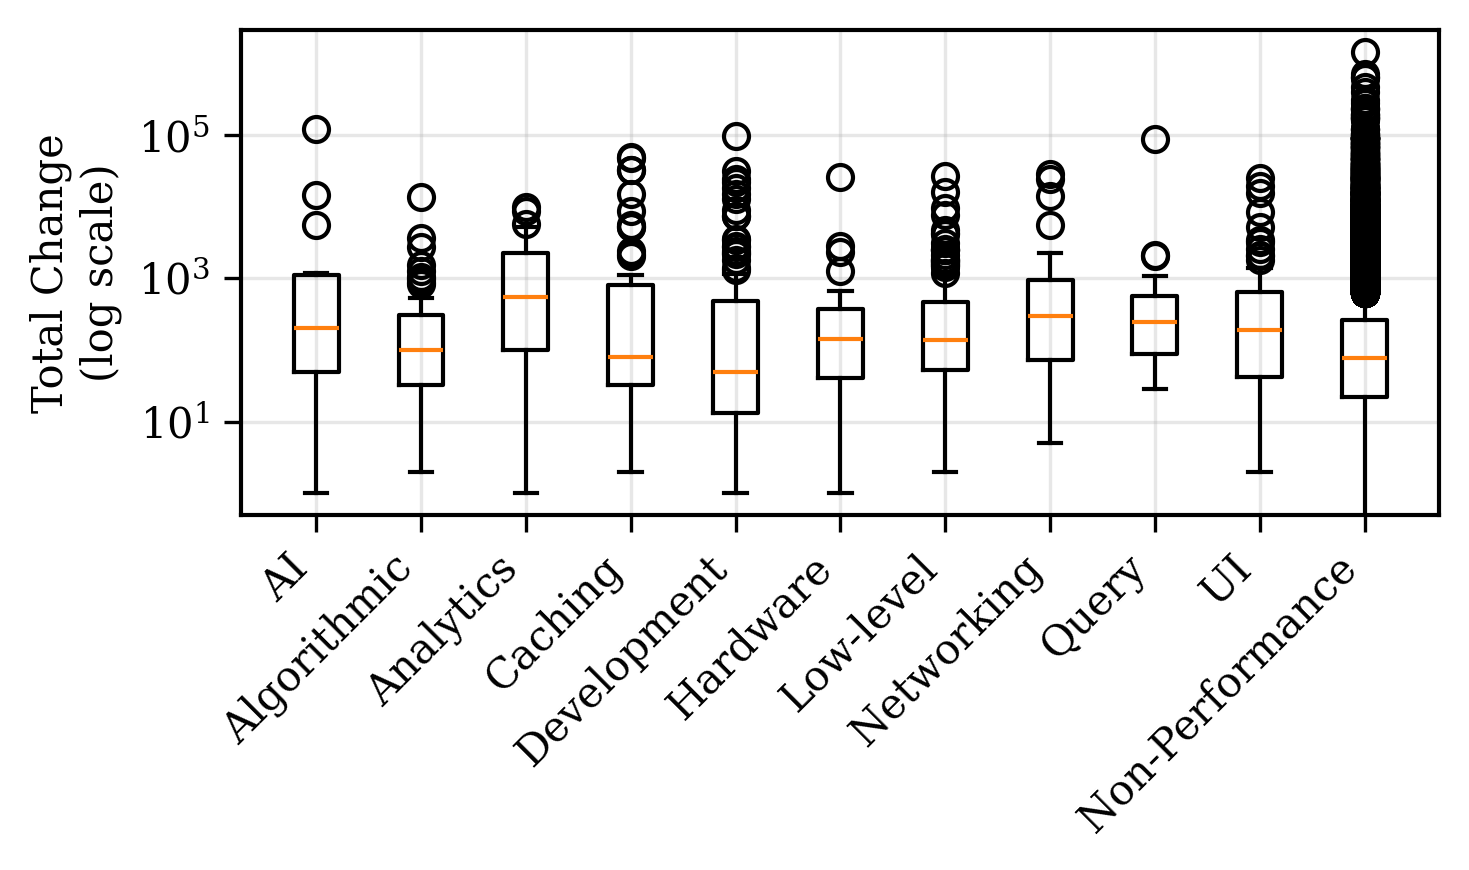

In [19]:
changes = []
median = []
labels = []

for category, df in category_dfs.items():
    df = df.copy()[~pd.isna(df["merged_at"])]
    df = get_change_details(df)
    changes.append(df["changes"].values)
    median.append(np.median(df["changes"]))
    labels.append(category)
    
stat = pd.DataFrame({
    'Category': labels,
    'Median': median,
    'Changes': changes
})

stat = stat.sort_values(by='Category', ascending=True)

mask = stat['Category'] != "Non-Performance"

stat_unmoved = stat[mask]
stat_moved = stat[~mask]
stat = pd.concat([stat_unmoved, stat_moved], ignore_index=True)

plt.figure(figsize=(5, 3))
positions = np.arange(len(stat)) * 0.7
plt.boxplot(stat["Changes"], positions=positions, widths=0.3)
plt.xticks(positions, stat["Category"], rotation=45, ha='right')
plt.yscale('log')
plt.ylabel(f'Total Change\n(log scale)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("./Outputs/Figures/RQ2_TotalChanges_by_Category.pdf", dpi=300, bbox_inches='tight', format='pdf')
plt.show()


In [20]:
from scipy.stats import ranksums
from itertools import combinations

# Perform pairwise Wilcoxon rank-sum test and Cliff's Delta
categories = stat['Category'].tolist()
results = []

for cat1, cat2 in combinations(range(len(categories)), 2):
    data1 = stat.iloc[cat1]['Changes']
    data2 = stat.iloc[cat2]['Changes']
    
    # Wilcoxon rank-sum test
    statistic, p_value = ranksums(data1, data2)
    
    # Cliff's Delta
    delta = CliffsDelta.cliffsDelta(data1, data2)
    
    results.append({
        'Category 1': categories[cat1],
        'Category 2': categories[cat2],
        'W-statistic': statistic,
        'p-value': p_value,
        'is_significant': p_value < 0.05,
        'Cliff\'s Delta': delta[0],
        'Effect Size': delta[1],
    })

comparison_df = pd.DataFrame(results)
comparison_df

,Category 1,Category 2,W-statistic,p-value,is_significant,Cliff's Delta,Effect Size
0,AI,Algorithmic,1.155044,0.248072,False,0.195238,small
1,AI,Analytics,-0.751730,0.452214,False,-0.140476,negligible
2,AI,Caching,0.780065,0.435352,False,0.132121,negligible
3,AI,Development,1.450162,0.147013,False,0.230252,small
4,AI,Hardware,0.669374,0.503257,False,0.125926,negligible
5,AI,Low-level,0.669010,0.503489,False,0.104215,negligible
6,AI,Networking,-0.240040,0.810299,False,-0.040741,negligible
7,AI,Query,-0.057054,0.954502,False,-0.010417,negligible
8,AI,UI,0.357473,0.720737,False,0.059487,negligible
9,AI,Non-Performance,1.607663,0.107909,False,0.239738,small


In [21]:

# Perform Wilcoxon rank-sum test and Cliff's Delta for Performance vs Non-Performance
perf_changes = stat[stat['Category'] != 'Non-Performance']['Changes'].explode()
non_perf_changes = stat[stat['Category'] == 'Non-Performance']['Changes'].explode()

# Wilcoxon rank-sum test
statistic, p_value = ranksums(perf_changes, non_perf_changes)

# Cliff's Delta
delta = CliffsDelta.cliffsDelta(perf_changes, non_perf_changes)

print(f"Performance vs Non-Performance Total Changes")
print(f"W-statistic: {statistic}")
print(f"p-value: {p_value}")
print(f"Significant (p < 0.05): {p_value < 0.05}")
print(f"Cliff's Delta: {delta[0]}")
print(f"Effect Size: {delta[1]}")

Performance vs Non-Performance Total Changes
W-statistic: 7.207151010344971
p-value: 5.713463136529711e-13
Significant (p < 0.05): True
Cliff's Delta: 0.16865875096376254
Effect Size: small
